# HighDimBiff Demo

You can run this 
* either on the cluster, by first converting this notebook to a script via ''jupyter nbconvert --to script run_mc.ipynb --template=nbconv.tpl'', then calling it from the command line via a slurm script with an extra argument specifying the amount of processes that can be allocated 
    * the conversion works on all notebook cells that have a tag 'export' (view -> cell toolbar -> tags)
* interactivly on your own computer with this notebook!


In [1]:
if isdefined(:cluster)
    using ClusterManagers
    N_tasks = parse(Int, ARGS[1])
    N_worker = N_tasks 
    addprocs(SlurmManager(N_worker))
    
else
    #addprocs(3)
    import Plots
end

@everywhere using LSODA
@everywhere using LightGraphs
using JLD2, FileIO, Clustering
@everywhere using DifferentialEquations
@everywhere using Distributions
@everywhere using HighBifLib  

# these imports invoke a lot of warnings when executed with multiple processes
# this seems to me to be more a bug of julia than an actual problem with this code
# imported on a single process there are no warnings

# Example 1: Order Parameter of Kuramoto Osc. 

We vary the initial conditions and the coupling strength. This is just to demonstrate how these kind of experiments are setup

**To-Do/Comment:** I am still very confused why and in which cases the @everywhere is needed. In this case the code doesn't work without any of the everywheres, but this goes against most of the explanations in the documentation.

In [19]:
@everywhere N = 30
@everywhere K = 0.5
@everywhere nd = Normal(0.5, 0.5) # distribution for eigenfrequencies # mean = 0.5Hz, std = 0.5Hz
@everywhere w_i_par = rand(nd,N) 

@everywhere net = erdos_renyi(N, 0.2)
@everywhere A = adjacency_matrix(net)


@everywhere ic = zeros(N)
@everywhere ic_dist = Uniform(-pi,pi)
@everywhere kdist = Uniform(0,10)
@everywhere ic_ranges = ()->rand(ic_dist)
@everywhere N_ics = 4000
#@everywhere ic_ranges = [-pi:pi/2:pi/2 for i=1:N]
#@everywhere K_range = 0.0:1:10.
@everywhere K_range = ()->rand(kdist)
@everywhere pars = kuramoto_network_parameters(K, w_i_par, N, A)

# base problem
@everywhere rp = ODEProblem(kuramoto_network, ic, (0.,500.), pars)

# setup the MC problem with the helper function from the library
@everywhere (ic_coupling_problem, ic_par, N_mc) = setup_ic_par_mc_problem(rp, ic_ranges, N_ics, pars, (:K, K_range))

# for this first example we are only interested in the order parameter of the kuramoto model

# define the MC Problem
ko_mcp = MonteCarloProblem(rp, prob_func=ic_coupling_problem, output_func=eval_ode_run)
tail_frac = 0.9 # 
ko_emcp = EqMCProblem(ko_mcp, N_mc, tail_frac) 
ko_sol = solve(ko_emcp)




HighBifLib.myMCSol(MonteCarloSolution Solution of length 4000 with uType:
Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1},Float64}, 4000, 400, 4)

In [20]:
D = distance_matrix(ko_sol, ic_par[:,end]);
k = 4
fdist = k_dist(D,k);

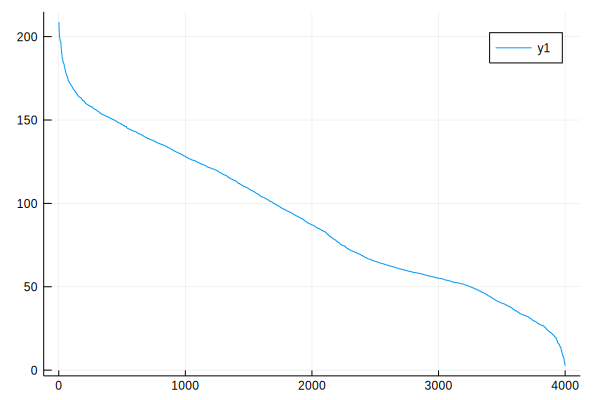

In [23]:
x = collect(1:ko_sol.N_mc)
Plots.plot(x[1:end],fdist[1:end])

In [24]:
db_eps = 150
db_res = dbscan(full(D),db_eps,k)


Clustering.DbscanResult([1, 2, 117, 1318, 2377, 3450, 3901], [1, 2, 1, 2, 2, 2, 2, 1, 2, 2  …  2, 1, 2, 1, 2, 1, 2, 2, 2, 2], [1481, 2135, 162, 10, 4, 3, 4])

In [25]:
cluster_meas = cluster_measures(ko_sol,db_res);
cluster_n = cluster_n_noise(db_res);
cluster_members = cluster_membership(ic_par[:,end],db_res,0.2,0.05);

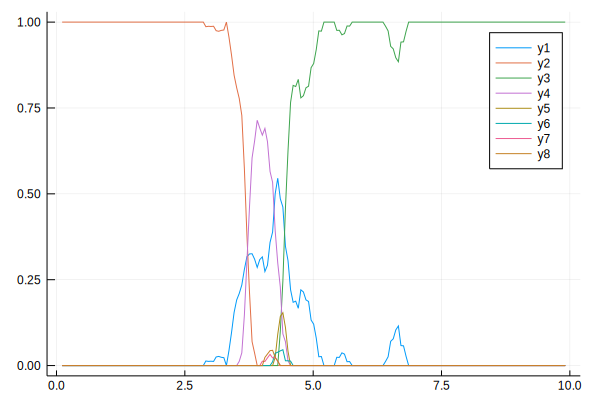

In [26]:
using Plots
plot(cluster_members[1],cluster_members[2])

# Example 2: Logistic Map

In [2]:
@everywhere rdist = Uniform(2.5,4)
@everywhere icdist = Uniform(0.1,0.99)
@everywhere r = ()->rand(rdist)
@everywhere pars = logistic_parameters(r())
@everywhere ic_ranges = ()->rand(icdist)
@everywhere N_ic = 5000
@everywhere dp = DiscreteProblem(logistic, ic_ranges(), (0.,5000.), pars)
@everywhere (ic_r_prob, ic_par, N_mc) = setup_ic_par_mc_problem(dp, ic_ranges, N_ic, pars, (:r, r))

In [4]:
log_mcp = MonteCarloProblem(dp, prob_func=ic_r_prob, output_func=eval_ode_run)
tail_frac = 0.8
log_emcp = EqMCProblem(log_mcp, N_mc, tail_frac)
log_sol = solve(log_emcp)

if isdefined(:cluster)
    @save "mc_log.jld2" log_sol
end 

In [5]:
log_sol.sol.u

5000-element Array{Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1},Float64},1}:
 ([0.540808], [0.334754], [9.41387], 0.891478)
 ([0.622905], [5.55389e-16], [0.0], 0.0)      
 ([0.663212], [0.0819707], [280.603], 1.0)    
 ([0.669664], [0.2002], [6.39054], 0.890993)  
 ([0.656704], [0.139202], [133.647], 1.0)     
 ([0.602152], [6.13502e-16], [0.0], 0.0)      
 ([0.646276], [0.22173], [18.5434], 0.955754) 
 ([0.605145], [1.72266e-15], [0.0], 0.0)      
 ([0.605687], [2.83248e-16], [0.0], 0.0)      
 ([0.666778], [0.20482], [6.33463], 0.896716) 
 ([0.661855], [0.0968075], [297.764], 1.0)    
 ([0.588235], [0.30263], [8.37888], 0.909493) 
 ([0.641558], [4.58093e-16], [0.0], 0.0)      
 ⋮                                            
 ([0.655094], [0.15185], [137.07], 1.0)       
 ([0.646017], [0.20923], [118.858], 0.974359) 
 ([0.606794], [0.0], [0.0], 0.0)              
 ([0.650257], [0.179958], [146.151], 1.0)     
 ([0.623398], [1.66998e-15], [0.0], 0.0)      
 ([0.655951], [0.1

In [ ]:
@load "mc_log.jld2" log_sol

In [15]:
D = @time distance_matrix(log_sol, ic_par[:,end], [1,0.5,0.05,0.,1]);
k = 4
fdist = @time k_dist(D,k);

if isdefined(:cluster)
    @save "mc_log_d.jld2" D
end

 10.236861 seconds (234.90 M allocations: 7.504 GiB, 15.31% gc time)
  1.436604 seconds (44.50 k allocations: 382.989 MiB, 2.34% gc time)


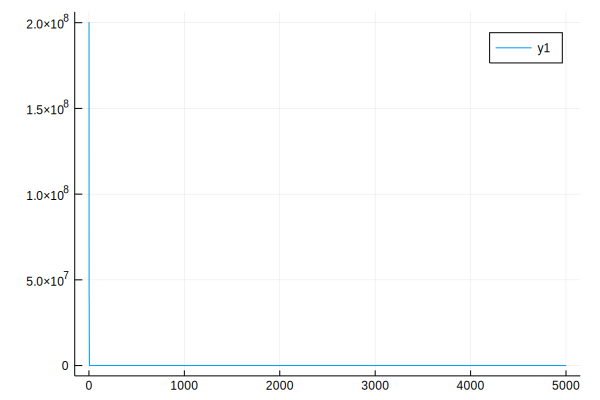

In [8]:
x = collect(1:log_sol.N_mc)
Plots.plot(x[1:end],fdist[1:end])

In [9]:
db_eps = 0.05

0.05

In [16]:
db_res = dbscan(full(D),db_eps,k)


Clustering.DbscanResult([1, 2, 3, 4, 5, 11, 15, 16, 17, 20  …  496, 619, 842, 873, 911, 1230, 1372, 1396, 2048, 3137], [1, 2, 3, 4, 5, 2, 4, 2, 2, 4  …  2, 15, 2, 17, 2, 4, 1, 4, 1, 8], [455, 1670, 41, 767, 68, 35, 54, 232, 10, 11  …  4, 16, 8, 19, 11, 4, 4, 6, 7, 4])

In [17]:
cluster_meas = cluster_measures(log_sol,db_res);
cluster_n = cluster_n_noise(db_res);
cluster_members = cluster_membership(ic_par[:,end],db_res,0.05,0.025);

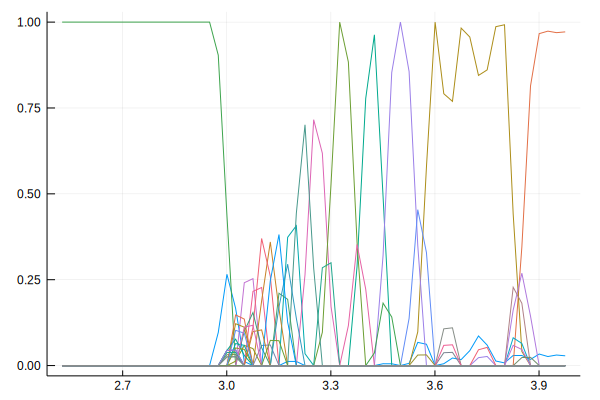

In [18]:
using Plots
plot(cluster_members[1],cluster_members[2],legend=false)

In [6]:
ic_par[890:900,end]

11-element Array{Float64,1}:
 3.0 
 3.0 
 3.05
 3.05
 3.05
 3.05
 3.05
 3.05
 3.05
 3.05
 3.05

In [6]:
log_sol.sol.u[890:900]

11-element Array{NTuple{4,Array{Float64,1}},1}:
 ([0.666645], [0.00350825], [1.91967], [0.991775])
 ([0.666645], [0.00351551], [1.91557], [0.99174]) 
 ([0.663861], [0.0738073], [-0.15934], [1.0])     
 ([0.663861], [0.0738073], [-0.15934], [1.0])     
 ([0.663861], [0.0738073], [-0.15934], [1.0])     
 ([0.664008], [0.0738073], [-0.159337], [1.0])    
 ([0.664008], [0.0738073], [-0.159337], [1.0])    
 ([0.664008], [0.0738073], [-0.159337], [1.0])    
 ([0.664008], [0.0738073], [-0.159337], [1.0])    
 ([0.664008], [0.0738073], [-0.159337], [1.0])    
 ([0.664008], [0.0738073], [-0.159337], [1.0])    

In [3]:
soli=solve(ic_r_prob(dp, 893, false));
#eval_ode_run(soli, 893)
tail = soli[1,4000:5000]
#using StatsBase
#v = var(tail)


1001-element Array{Float64,1}:
 0.737705
 0.590164
 0.737705
 0.590164
 0.737705
 0.590164
 0.737705
 0.590164
 0.737705
 0.590164
 0.737705
 0.590164
 0.737705
 ⋮       
 0.590164
 0.737705
 0.590164
 0.737705
 0.590164
 0.737705
 0.590164
 0.737705
 0.590164
 0.737705
 0.590164
 0.737705

In [5]:
eval_ode_run(soli,893)

[0.298595, 0.63878, 0.703757, 0.635873, 0.706193, 0.632828, 0.708688, 0.62967, 0.711216, 0.626433, 0.713745, 0.623155, 0.71624, 0.619882, 0.718666, 0.616665, 0.720987, 0.613552, 0.723173, 0.610591, 0.725197, 0.607823, 0.727042, 0.605279, 0.728695, 0.602981, 0.730155, 0.600938, 0.731425, 0.599149, 0.732517, 0.597605, 0.733444, 0.596288, 0.734223, 0.595176, 0.734871, 0.594248, 0.735408, 0.593479, 0.735848, 0.592845, 0.736208, 0.592327, 0.736501, 0.591906, 0.736738, 0.591563, 0.736929, 0.591287, 0.737083, 0.591064, 0.737207, 0.590884, 0.737307, 0.59074, 0.737387, 0.590625, 0.737451, 0.590532, 0.737502, 0.590458, 0.737543, 0.590399, 0.737576, 0.590351, 0.737602, 0.590314, 0.737623, 0.590283, 0.737639, 0.590259, 0.737652, 0.59024, 0.737663, 0.590225, 0.737672, 0.590212, 0.737678, 0.590203, 0.737684, 0.590195, 0.737688, 0.590188, 0.737691, 0.590184, 0.737694, 0.59018, 0.737696, 0.590176, 0.737698, 0.590174, 0.737699, 0.590172, 0.737701, 0.59017, 0.737701, 0.590169, 0.737702, 0.590168, 0.7377

 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164,

 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705,

 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164,

 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164, 0.737705, 0.590164,

(([0.663879], [0.0738303], [32.983], [0.871747]), false)

In [ ]:
tsave_array()

In [26]:
empirical_1D_KL_divergence(tail,0.664008,0.00544)

46.430647468454666

In [79]:
log_sol.sol.u[800:900]

101-element Array{NTuple{4,Array{Float64,1}},1}:
 ([0.661017], [1.94221e-15], [0.0], [1.0])        
 ([0.661017], [1.94221e-15], [0.0], [1.0])        
 ([0.661017], [1.94221e-15], [0.0], [1.0])        
 ([0.661017], [1.94221e-15], [0.0], [1.0])        
 ([0.661017], [1.94221e-15], [0.0], [1.0])        
 ([0.661017], [1.94221e-15], [0.0], [1.0])        
 ([0.661017], [1.94221e-15], [0.0], [1.0])        
 ([0.661017], [1.94392e-15], [0.0], [1.0])        
 ([0.661017], [1.94392e-15], [0.0], [1.0])        
 ([0.661017], [1.94392e-15], [0.0], [1.0])        
 ([0.661017], [1.94392e-15], [0.0], [1.0])        
 ([0.666645], [0.00351551], [1.91557], [0.99174]) 
 ([0.666645], [0.00350825], [1.91967], [0.991775])
 ⋮                                                
 ([0.666645], [0.00344767], [1.95428], [0.992064])
 ([0.666645], [0.00350825], [1.91967], [0.991775])
 ([0.666645], [0.00351551], [1.91557], [0.99174]) 
 ([0.663861], [0.0738073], [-0.15934], [1.0])     
 ([0.663861], [0.0738073], [-0.15

In [77]:
ic_par[850,:]

2-element Array{Float64,1}:
 0.49
 3.0 

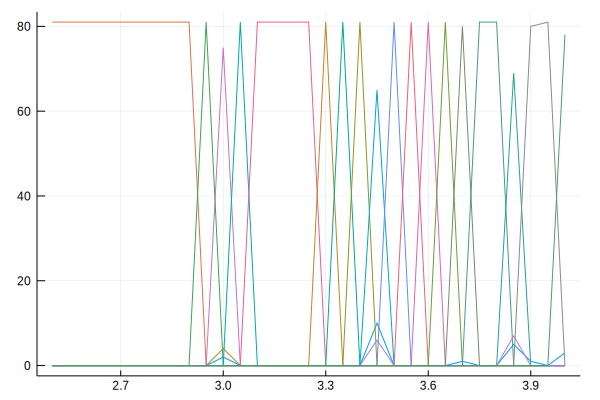

In [58]:
using Plots
plot(r,cluster_members,legend=false)

In [57]:
cluster_meas[4,:,:]

4×1 Array{Float64,2}:
 0.0199118 
 0.00010471
 0.0573831 
 0.0296233 

# Example 3: Roessler Network

In [10]:
@everywhere N = 5

@everywhere k = 2
@everywhere p = 0.2
@everywhere net = watts_strogatz(N, k, p)

#@everywhere A = [0 1 1 
#    1 0 1 
#    1 1 0 ]
#@everywhere net = Graph(A)

@everywhere L = laplacian_matrix(net)

@everywhere a = ones(N).*0.2
@everywhere b = ones(N).*0.2
@everywhere c = ones(N).*7.0

tail_frac = 0.8

# for reference get the synchronizable range of Ks
evals = eig(full(L))[1]
evals = sort!(evals[evals .> 1e-5])
lambda_min = evals[end]
lambda_max = evals[1]
K_sync = (0.1232/lambda_min, 4.663/lambda_max)

(0.034051642517202586, 3.374178497908152)

In [11]:
#@everywhere K_range = [0.002, 0.004, 0.006, 0.008, 0.010, 0.03, 0.05, 0.1, 0.2, 0.5, 1, 2, 4]
@everywhere K_range = [0.002, 0.004, 0.03, 0.5, 1, 4]
#@everywhere K_range = [0.002, 0.005, 0.01, 0.025, 0.05, 0.07, 0.5, 1, 2]
#@everywhere K_range = [0.005, 0.007, 0.009, 0.011, 0.013, 0.016, 0.02, 0.03, 0.04, 0.9, 1.5, 2]
@everywhere ic_gen_xy = Uniform(-15.,15.)
@everywhere ic_gen_z = Uniform(-5.,20.)

@everywhere ic_gens = [()->rand(ic_gen_xy), ()-> rand(ic_gen_xy), ()->rand(ic_gen_z)]
@everywhere N_ic = 5


@everywhere rp = ODEProblem(roessler_network, zeros(3*N), (0.,100.), roessler_parameters(a,b,c,0.05,L,N))
@everywhere (ic_coupling_problem, ic_par, N_mc) = setup_ic_par_mc_problem(rp, ic_gens, N_ic, roessler_parameters(a,b,c,0.05,L,N),(:K,K_range))


In [5]:
rn_mcp = MonteCarloProblem(rp, prob_func=ic_coupling_problem, output_func=eval_ode_run_inf)
rn_emcp = EqMCProblem(rn_mcp, N_mc, tail_frac)
@time rn_sol = solve(rn_emcp)

@save "mc_roes_sol.jld2" rn_sol ic_par rn_emcp

if isdefined(:cluster)
    @save "mc_roes_sol.jld2" rn_sol ic_par rn_emcp
end 

  5.997917 seconds (35.68 M allocations: 865.371 MiB, 3.45% gc time)


In [2]:
@load "mc_roes_sol.jld2" rn_sol ic_par rn_empc
#@load "mc_roes_ic_par_inf.jld2" ic_par

LoadError: [91mKeyError: key "rn_empc" not found[39m

In [ ]:
D = distance_matrix(rn_sol);
k = 4
fdist = k_dist(D,k);

In [ ]:
x = collect(1:rn_sol.N_mc)
Plots.plot(x[1:end],fdist[1:end])

In [ ]:
eps = 6e8
db_res = dbscan(D,eps,k)
cluster_meas = cluster_measures(rn_sol, db_res)

# Example 4: Lotka Volterra

High Dimensional (N>=4) Lotka Volterra system can exhibit all kinds of interessting dynamics. Maybe it makes sense to study them with these tools

First we study the 4-dim model: $\frac{dN_i}{dt} = b_iN_i\left(1-\sum_{j=1}^n a_{ij}N_j\right),\qquad 1\leq i\leq n$

The parameter configuration

$ a = \left[ \begin{array}{cccc}
        1 & 1.09 & 1.52 & 0\\
        0 & 1 & 0.44 & 1.36\\
        2.33 & 0 & 1 & 0.47\\
        1.21 & 0.51 & 0.35 & 1\\
        \end{array} \right] $
        
$ b = \left(1, 0.72, 1.53, 1.27\right)$

is known to exhibit chaos with a strange attractor. Lets scan around these parameters.

In [9]:
@everywhere N = 4

@everywhere a = [1 1.09 1.52 0
                 0 1 0.44 1.36
                 2.33 0 1 0.47
                 1.21 0.51 0.35 1
                ]
@everywhere b = [1, 0.72, 1.53, 1.27]

@everywhere a12 = 0.69:0.1:2.59
@everywhere var_a = [a for i=1:length(a12)]
for i=1:length(a12)
        var_a[i][1,2] = a12[i]
end 

tail_frac = 0.8
@everywhere ic_gen = Uniform(-0.99,0.99)

@everywhere ic_gens = [()->rand(ic_gen)]
@everywhere N_ic = 100

@everywhere lvp = ODEProblem(lotka_volterra, zeros(N), (0.,100.), lotka_volterra_parameters(a,b,N))
@everywhere (ic_a_problem, ic_par, N_mc) = setup_ic_par_mc_problem(lvp, ic_gens, N_ic, lotka_volterra_parameters(a,b,N),(:a,var_a))


LoadError: [91m[91m[91mUndefVarError: Uniform not defined[39m
eval(::Module, ::Any) at ./boot.jl:235
eval_ew_expr at ./distributed/macros.jl:116 [inlined]
(::Base.Distributed.##135#136{Base.Distributed.#eval_ew_expr,Tuple{Expr},Array{Any,1}})() at ./distributed/remotecall.jl:319
run_work_thunk(::Base.Distributed.##135#136{Base.Distributed.#eval_ew_expr,Tuple{Expr},Array{Any,1}}, ::Bool) at ./distributed/process_messages.jl:56
#remotecall_fetch#140(::Array{Any,1}, ::Function, ::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:344
remotecall_fetch(::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:344
#remotecall_fetch#144(::Array{Any,1}, ::Function, ::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
remotecall_fetch(::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
(::##85#87)() at ./distributed/macros.jl:102[39m
#remotecall_fetch#140(::Array{Any,1}, ::Function, ::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:345
remotecall_fetch(::Function, ::Base.Distributed.LocalProcess, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:344
#remotecall_fetch#144(::Array{Any,1}, ::Function, ::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
remotecall_fetch(::Function, ::Int64, ::Expr, ::Vararg{Expr,N} where N) at ./distributed/remotecall.jl:372
(::##85#87)() at ./distributed/macros.jl:102[39m

In [8]:
lvp_mcp = MonteCarloProblem(lvp, prob_func=ic_a_problem, output_func=eval_ode_run_repeat)
lvp_emcp = EqMCProblem(lvp_mcp, N_mc, tail_frac)
@time lvp_sol = solve(lvp_emcp)

if isdefined(:cluster)
    @save "mc_lv_sol.jld2" lvp_sol
    @save "mc_lv_ic_par.jld2" ic_par
end 

4×4 Array{Float64,2}:
 1.0   2.59  1.52  0.0 
 0.0   1.0   0.44  1.36
 2.33  0.0   1.0   0.47
 1.21  0.51  0.35  1.0 

# Example 5: Henon Map

In [ ]:
@everywhere a = 2.5:0.02:4
@everywhere pars = henon_parameters(1,1)
@everywhere ic_ranges = [0.1:0.005:0.9]
@everywhere hmp = DiscreteProblem(henon, ic_ranges[1][1], (0.,500.), pars)
@everywhere (ic_r_prob, ic_par, N_mc) = setup_ic_par_mc_problem(hmp, ic_ranges, pars, (:a, a))

hm_mcp = MonteCarloProblem(dp, prob_func=ic_r_prob, output_func=eval_ode_run)
tail_frac = 0.8
hm_emcp = EqMCProblem(hm_mcp, N_mc, tail_frac)
hm_sol = solve(hm_emcp)

if isdefined(:cluster)
    @save "mc_log.jld2" hm_sol
end 